In [1]:
##H1 SHOWING PACKAGES BEING INSTALLED

import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
##H1 SHOWING PARSING OF WIKIPEDIA VIA BEAUTIFULSOUP
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [3]:
##H1 SHOWING DATAFRAME BEING GROUPED BY POSTALCODE, BOROUGH AND NEIGHBOURHOOD

df = df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(", ".join).reset_index()
df.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [4]:
# Dropping the rows where Borough is 'Not assigned'
df1 = df[df.Borough != 'Not assigned']

In [5]:
df2 = df1.groupby(['PostalCode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

In [6]:
df2['Neighborhood'] = np.where(df2['Neighborhood'] == 'Not assigned',df2['Borough'], df2['Neighborhood'])

df2

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [7]:
##RENAMING COLUMNS
df2.rename(columns={'Postal Code':'Postcode'},inplace=True)

In [ ]:
##USING FOURSQUARE TO GET NEIGHBOURHOOD INFORMATION
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=5000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [8]:
## LOADING GEOSPATIAL DATA
lat_lon = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lon.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
## RENAMING NEW GEOSPATIAL DATAFRAME
lat_lon.rename(columns={'Postal Code':'PostalCode'},inplace=True)
lat_lon.head()


,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
## MERGING TABLES
df3 = pd.merge(df2,lat_lon,on='PostalCode')
df3.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [11]:
##SELECTING VALUES FOR SCARBOROUGH AND MAKING NEW TABLE
df4 = df3[df3['Borough'].str.contains('Scarborough',regex=False)]
df4

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [12]:
## MAPPING THE NEIGHBOURHOODS OF SCARBOROUGH
map_scar = folium.Map(location=[43.806686,-79.194353],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(df4['Latitude'],df4['Longitude'],df4['Borough'],df4['Neighborhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_scar)
map_scar

In [13]:
## PRODUCING THE K-MEANS ML MODEL
k=5
scar_clustering = df4.drop(['PostalCode','Borough','Neighborhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(scar_clustering)
kmeans.labels_
df4.insert(0, 'Cluster Labels', kmeans.labels_)

In [15]:

## CREATING THE K-MEANS CLUSTERS ON MAP USING FOLIUM
map_clusters = folium.Map(location=[43.651070,-79.347015],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df4['Latitude'], df4['Longitude'], df4['Neighborhood'], df4['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [16]:
## LOADING THE CRIME DATA
df_can = pd.read_csv(r"C:\Users\40314820\Downloads\Neighbourhood_Crime_Rates.csv")

In [17]:
##RENAMING THE CRIME DATA HEADINGS
df_can = df_can.rename(columns = {'Neighbourhood' : 'Neighborhood'})
df_can

,OBJECTID,Neighborhood,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_2020,AutoTheft_2014,...,Shootings_2014,Shootings_2015,Shootings_2016,Shootings_2017,Shootings_2018,Shootings_2019,Shootings_2020,Postcode,Latitude,Longitude
0,42,West Humber-Clairville,289,307,296,303,316,256,248,306,...,5,7,12,11,16,19,7,NaN,NaN,NaN
1,99,Mount Olive-Silverstone-Jamestown,239,236,271,276,257,279,203,62,...,5,11,6,6,15,12,16,NaN,NaN,NaN
2,8,Thistletown-Beaumond Heights,61,56,46,56,53,75,56,10,...,0,1,2,2,1,3,1,NaN,NaN,NaN
3,104,Rexdale-Kipling,49,62,72,87,79,62,48,12,...,1,0,4,2,3,5,1,NaN,NaN,NaN
4,79,Elms-Old Rexdale,45,50,69,61,56,72,48,7,...,1,4,3,6,3,7,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,41,West Hill,347,395,422,412,425,445,336,24,...,0,1,6,3,5,8,7,M1E,43.784535,-79.160497
136,112,Woburn,351,396,365,405,391,433,348,46,...,2,6,4,7,12,15,15,M1G,43.770992,-79.216917
137,78,Eglinton East,189,182,209,209,188,199,153,18,...,1,2,3,10,1,6,11,NaN,NaN,NaN
138,15,Scarborough Village,161,153,191,149,179,174,178,20,...,1,2,3,5,4,6,2,M1J,43.744734,-79.239476


In [18]:
##DROPPING MISSING VALUES
df_can = df_can.dropna()
df_can

,OBJECTID,Neighborhood,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_2020,AutoTheft_2014,...,Shootings_2014,Shootings_2015,Shootings_2016,Shootings_2017,Shootings_2018,Shootings_2019,Shootings_2020,Postcode,Latitude,Longitude
48,46,Bayview Woods-Steeles,36,43,37,34,41,45,33,16,...,0,0,1,0,3,4,1,M1W,43.799525,-79.318389
105,11,Humewood-Cedarvale,34,47,51,39,44,45,42,10,...,0,0,0,1,0,0,0,M1H,43.773136,-79.239476
115,127,Steeles,44,35,45,43,31,47,42,19,...,2,0,0,0,1,0,2,M1V,43.815252,-79.284577
116,84,L'Amoreaux,126,160,173,176,162,197,193,16,...,2,2,7,11,7,9,9,M1V,43.815252,-79.284577
117,6,Tam O'Shanter-Sullivan,103,88,100,120,131,108,131,22,...,0,3,2,2,4,2,2,M1T,43.781638,-79.304302
118,77,Wexford/Maryvale,190,217,202,202,210,245,174,53,...,3,2,4,3,4,3,2,M1R,43.750072,-79.295849
119,24,Clairlea-Birchmount,244,252,235,243,281,287,184,42,...,3,5,0,0,6,3,2,M1L,43.711112,-79.284577
120,74,Oakridge,158,183,141,166,166,161,157,21,...,3,12,3,6,5,2,8,M1L,43.711112,-79.284577
121,90,Birchcliffe-Cliffside,139,131,198,158,199,207,142,12,...,0,0,0,0,1,2,0,M1M,43.716316,-79.239476
122,25,Cliffcrest,81,99,110,119,138,137,111,17,...,0,2,0,0,1,1,2,M1M,43.716316,-79.239476


In [19]:
## MAKING NEW MAP
latitude = 43.815
longitude = -79.318
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

In [20]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(df_can.Latitude, df_can.Longitude):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
Toronto_map.add_child(incidents)

In [21]:
## MAKING A TOTAL CRIMES COLUMN
df_can['Total_Crimes'] = df_can['Assault_2014'] + df_can['Assault_2015'] +df_can['Assault_2016'] +df_can['Assault_2017'] +df_can['Assault_2018'] +df_can['Assault_2019'] +df_can['Assault_2020'] +df_can['Shootings_2015'] +df_can['Shootings_2016'] +df_can['Shootings_2017'] +df_can['Shootings_2018'] +df_can['Shootings_2019'] +df_can['Shootings_2020'] +df_can['AutoTheft_2014'] +df_can['AutoTheft_2015'] +df_can['AutoTheft_2016'] +df_can['AutoTheft_2017'] +df_can['AutoTheft_2018'] +df_can['AutoTheft_2019'] +df_can['AutoTheft_2020'] +df_can['BreakAndEnter_2014'] +df_can['BreakAndEnter_2015'] +df_can['BreakAndEnter_2016'] +df_can['BreakAndEnter_2017'] +df_can['BreakAndEnter_2018'] +df_can['BreakAndEnter_2019'] +df_can['BreakAndEnter_2020'] +df_can['Robbery_2014'] +df_can['Robbery_2015'] +df_can['Robbery_2016'] +df_can['Robbery_2017'] +df_can['Robbery_2018'] +df_can['Robbery_2019'] +df_can['Robbery_2020'] +df_can['TheftOver_2014'] +df_can['TheftOver_2015'] +df_can['TheftOver_2016'] +df_can['TheftOver_2017'] +df_can['TheftOver_2018'] +df_can['TheftOver_2019'] +df_can['TheftOver_2020'] +df_can['Homicide_2014'] +df_can['Homicide_2015'] +df_can['Homicide_2016'] +df_can['Homicide_2017'] +df_can['Homicide_2018'] +df_can['Homicide_2019'] +df_can['Homicide_2020']


<ipython-input-21-3b91673fa9ac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_can['Total_Crimes'] = df_can['Assault_2014'] + df_can['Assault_2015'] +df_can['Assault_2016'] +df_can['Assault_2017'] +df_can['Assault_2018'] +df_can['Assault_2019'] +df_can['Assault_2020'] +df_can['Shootings_2015'] +df_can['Shootings_2016'] +df_can['Shootings_2017'] +df_can['Shootings_2018'] +df_can['Shootings_2019'] +df_can['Shootings_2020'] +df_can['AutoTheft_2014'] +df_can['AutoTheft_2015'] +df_can['AutoTheft_2016'] +df_can['AutoTheft_2017'] +df_can['AutoTheft_2018'] +df_can['AutoTheft_2019'] +df_can['AutoTheft_2020'] +df_can['BreakAndEnter_2014'] +df_can['BreakAndEnter_2015'] +df_can['BreakAndEnter_2016'] +df_can['BreakAndEnter_2017'] +df_can['BreakAndEnter_2

In [22]:
df_can.head()

,OBJECTID,Neighborhood,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_2020,AutoTheft_2014,...,Shootings_2015,Shootings_2016,Shootings_2017,Shootings_2018,Shootings_2019,Shootings_2020,Postcode,Latitude,Longitude,Total_Crimes
48,46,Bayview Woods-Steeles,36,43,37,34,41,45,33,16,...,0,1,0,3,4,1,M1W,43.799525,-79.318389,636
105,11,Humewood-Cedarvale,34,47,51,39,44,45,42,10,...,0,0,1,0,0,0,M1H,43.773136,-79.239476,746
115,127,Steeles,44,35,45,43,31,47,42,19,...,0,0,0,1,0,2,M1V,43.815252,-79.284577,918
116,84,L'Amoreaux,126,160,173,176,162,197,193,16,...,2,7,11,7,9,9,M1V,43.815252,-79.284577,2242
117,6,Tam O'Shanter-Sullivan,103,88,100,120,131,108,131,22,...,3,2,2,4,2,2,M1T,43.781638,-79.304302,1617


In [23]:
## RENAMING THE NEIGHBOURHOOD NAMES SO THEY MATCH THE GEOJSON FILE
#IF THIS IS NOT DONE THE CHOROPLETH WILL NOT WORK AS THEY MUST MATCH

df_can = df_can.replace(['Woburn'], 'Woburn (137)')
df_can = df_can.replace(['Bayview Woods-Steeles'], 'Bayview Woods-Steeles (49)')
df_can = df_can.replace(['Humewood-Cedarvale'], 'Humewood-Cedarvale (106)')
df_can = df_can.replace(['Steeles'], 'Steeles (116)')
df_can = df_can.replace(["L'Amoreaux"], "L'Amoreaux (117)")
df_can = df_can.replace(["Tam O'Shanter-Sullivan"], "Tam O'Shanter-Sullivan (118)")
df_can = df_can.replace(['Wexford/Maryvale'], 'Wexford/Maryvale (119)')
df_can = df_can.replace(['Clairlea-Birchmount '], 'Clairlea-Birchmount  (120)')
df_can = df_can.replace(['Oakridge'], 'Oakridge (121)')
df_can = df_can.replace(['Birchcliffe-Cliffside'], 'Birchcliffe-Cliffside (122)')
df_can = df_can.replace(['Cliffcrest'], 'Cliffcrest (123)')
df_can = df_can.replace(['Kennedy Park'], 'Kennedy Park (124)')
df_can = df_can.replace(['Ionview'], 'Ionview (125)')
df_can = df_can.replace(['Dorset Park'], 'Dorset Park (126)')
df_can = df_can.replace(['Agincourt North'], 'Agincourt North (129)')                
df_can = df_can.replace(['South-Malvern West'], 'South-Malvern West (128)')
df_can = df_can.replace(['Milliken'], 'Milliken (130)')                       
df_can = df_can.replace(['Rouge'], 'Rouge (131)')                      
df_can = df_can.replace(['Malvern'], 'Malvern (132)')                        
df_can = df_can.replace(['Centennial Scarborough'], 'Centennial Scarborough (133)')                         
df_can = df_can.replace(['Highland Creek'], 'Highland Creek (134)')
df_can = df_can.replace(['Morningside'], 'Morningside (135)')
df_can = df_can.replace(['West Hill'], 'West Hill (136)')
df_can = df_can.replace(['Scarborough Village'], 'Scarborough Village (139)')
df_can = df_can.replace(['Guildwood'], 'Guildwood (140)')


In [24]:
#DROPPING DUPLICATES
df_cana = df_can.drop_duplicates(subset='Latitude')
df_cana.shape


(14, 55)

In [67]:
#MAKING NEW DATAFRAME TO GROUP THE DATA BY NEIGHBOURHOOD
area_pie = df_cana.groupby('Neighborhood', axis=0).sum()

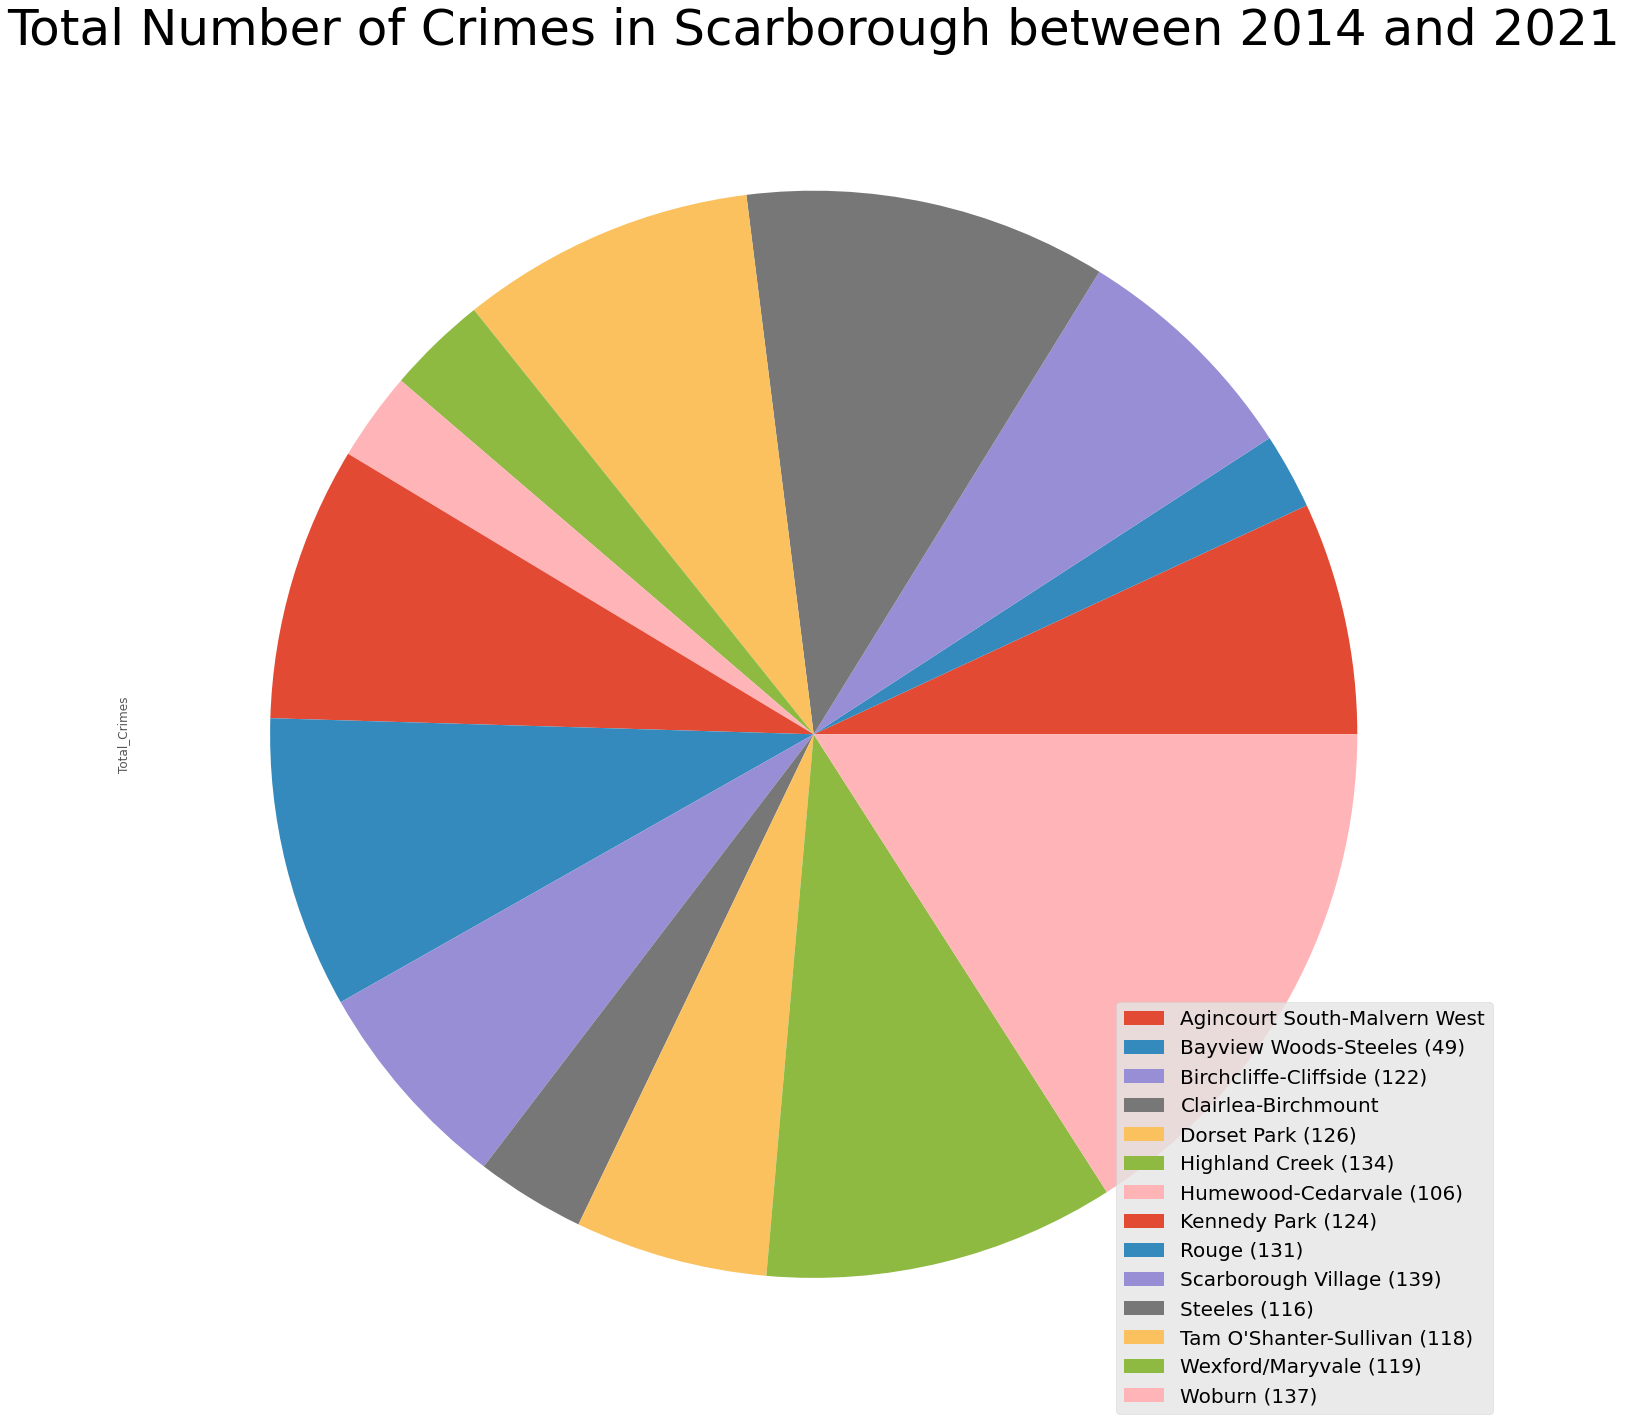

In [68]:
## PLOTTING THE PIE GRAPH
import matplotlib as mpl
plt.style.use('ggplot')
plt.rc('legend',fontsize=20)
plt.rc('legend', loc='upper left', borderaxespad=0)

plt.figure(figsize=(30,25))


area_pie['Total_Crimes'].plot.pie(subplots=True, figsize=(25,20), fontsize=30, labeldistance=None, legend=True)
plt.title('Total Number of Crimes in Scarborough between 2014 and 2021',
         fontsize=50)
plt.savefig('Total_Crime.jpg')
plt.show()

In [69]:
## SORTING THE DATA TO FIND LOWEST TOTAL CRIME PER NEIGHBOURHOOD
area_pplot = area_pie.sort_values(['Total_Crimes'], ascending = True, axis = 0)

In [70]:
##ASSIGNING THE TOP 5 SAFEST AREAS TO NEW DATAFRAME
top5 = area_pplot.head()
top5

,OBJECTID,Assault_2014,Assault_2015,Assault_2016,Assault_2017,Assault_2018,Assault_2019,Assault_2020,AutoTheft_2014,AutoTheft_2015,...,Shootings_2014,Shootings_2015,Shootings_2016,Shootings_2017,Shootings_2018,Shootings_2019,Shootings_2020,Latitude,Longitude,Total_Crimes
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Bayview Woods-Steeles (49),46,36,43,37,34,41,45,33,16,7,...,0,0,1,0,3,4,1,43.799525,-79.318389,636
Humewood-Cedarvale (106),11,34,47,51,39,44,45,42,10,5,...,0,0,0,1,0,0,0,43.773136,-79.239476,746
Highland Creek (134),72,52,50,73,68,50,64,33,25,11,...,0,2,0,1,3,1,1,43.784535,-79.160497,841
Steeles (116),127,44,35,45,43,31,47,42,19,16,...,2,0,0,0,1,0,2,43.815252,-79.284577,918
Tam O'Shanter-Sullivan (118),6,103,88,100,120,131,108,131,22,19,...,0,3,2,2,4,2,2,43.781638,-79.304302,1617


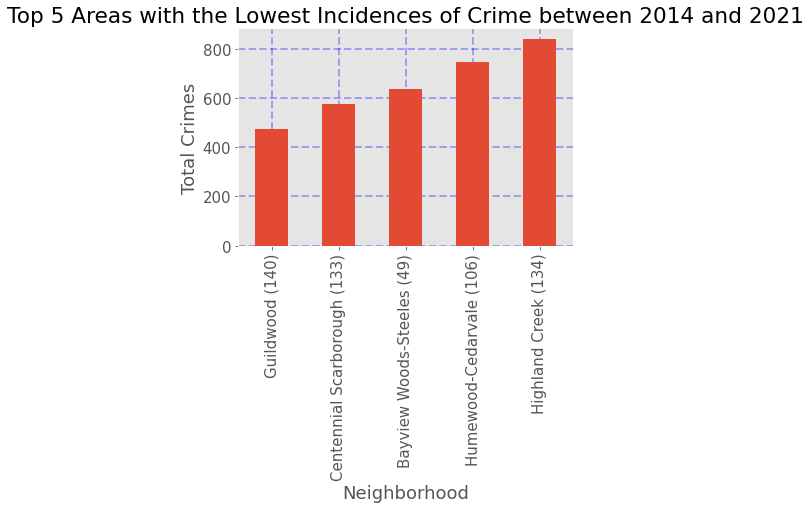

In [29]:
#PLOTTING BAR GRAPH OF TOP 5 SAFEST AREAS
top5['Total_Crimes'].plot(kind='bar')
plt.title('Top 5 Areas with the Lowest Incidences of Crime between 2014 and 2021')
plt.xlabel('Neighborhood')
plt.ylabel('Total Crimes')
plt.legend = None
plt.labels=None
plt.grid(color = 'blue', alpha = 0.3, linestyle = '--', linewidth =2)
plt.show
plt.savefig('Top_5_Safe.jpg', bbox_inches='tight', dpi=150)

In [30]:
##LOADING THE GEOJSON FILE
import geopandas as gpd
import pandas as pd
import requests
import io
    
# Downloading the csv file from your GitHub account

url = "https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_topo.json" # Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe

world_geo = gpd.read_file(io.StringIO(download.decode('utf-8')))

# Printing out the first 5 rows of the dataframe

print (world_geo.head())


   id                          name  \
0  97           Yonge-St.Clair (97)   
1  27  York University Heights (27)   
2  38         Lansing-Westgate (38)   
3  31       Yorkdale-Glen Park (31)   
4  16      Stonegate-Queensway (16)   

                                            geometry  
0  POLYGON ((-79.39122 43.68107, -79.39143 43.680...  
1  POLYGON ((-79.50531 43.75988, -79.50489 43.759...  
2  POLYGON ((-79.43996 43.76155, -79.44001 43.761...  
3  POLYGON ((-79.43970 43.70561, -79.44012 43.705...  
4  POLYGON ((-79.49263 43.64745, -79.49279 43.647...  


In [31]:
#Set the Coordinate Reference System
world_geo.crs = "EPSG:4326"

In [73]:
#PLOTTING THE KMEANS MAP
Toronto_map = folium.Map(location=[43.8, -79.4], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df4['Latitude'], df4['Longitude'], df4['Neighborhood'], df4['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Toronto_map)
Toronto_map

In [32]:
#PLOTTING THE KMEANS MAP OVER THE CHOROPLETH OF TOTAL CRIME
world_map = folium.Map(location=[43.8, -79.4], zoom_start=10)

world_map.choropleth(
    geo_data= world_geo,
    data= df_can,
    columns=['Neighborhood', 'Total_Crimes', 'Latitude', 'Longitude'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Crime in Scarborough'
)


# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df4['Latitude'], df4['Longitude'], df4['Neighborhood'], df4['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(world_map)
       


In [33]:
world_map

In [75]:
LIMIT = 500 
radius = 5000 
CLIENT_ID = 'ZMHWBS0SR12Z3YDYVHJVTZPRK3U1ZP3I2TYQAJ5CU3JUHMB5'
CLIENT_SECRET = 'H3TT0XT3P5TIAFCV1Y2UUVLF42N44DICNKLUELK34H2TKLFR'
VERSION = '20181020'